# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

In [2]:
df = pd.read_csv('bank_fin.csv', sep = ';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [3]:
#Исследуем данные на предмет пропусков
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

In [4]:
#Преобразуем признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].apply(lambda x: np.nan if x is np.nan else float((x.replace(' ', '').replace('$', '').replace(',', '.'))))

1529.129

In [5]:
#Обработаем пропуски в признаки balance, заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())

In [6]:
#Обработайем пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x == 'unknown' else x)

In [7]:
#Удалим все выбросы для признака balance
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x <= lower_bound) | (x >= upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    print(f'Нижняя граница: {lower_bound}. Верхняя граница {upper_bound}.')
    return outliers, cleaned

outliers, df = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df.shape[0]}')

Нижняя граница: -2241.0. Верхняя граница 4063.0.
Число выбросов по методу Тьюки: 1058
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


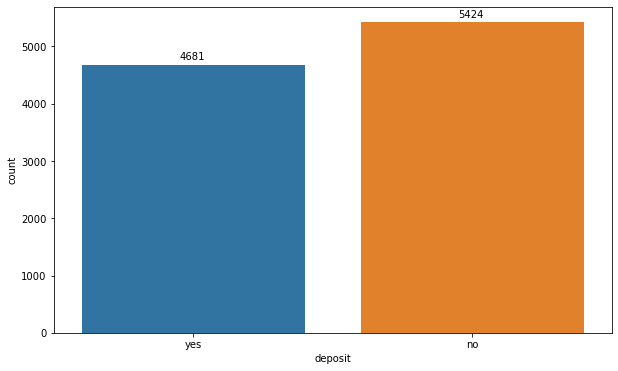

In [9]:
#Изучим соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируем результат
plt.figure(figsize=(10,6))
ax = sns.countplot(data=df, x='deposit')
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+90))

In [10]:
#Рассчитаем описательные статистики для категориальных переменных
print(f'Количество месяцев компании: {df.month.nunique()}')
print(f'Количество сфер занятости среди клиентов банка: {df.job.nunique()}')

Количество месяцев компании: 12
Количество сфер занятости среди клиентов банка: 11


In [11]:
#Узнаем, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
ds = df.groupby('poutcome')['deposit'].value_counts()
ds

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: deposit, dtype: int64

In [15]:
# Узнаем, в каком месяце чаще всего отказывались от предложения открыть депозит
ds = df.groupby('month')['deposit'].value_counts(sort=False)
fail_persent = []
for i in range (0, len(ds),2):
    dev = (ds[i]/(ds[i]+ds[i+1]))*100
    fail_persent.append(round(dev,2))

months =[]
for k in ds.index:
    m = k[0]
    if m not in months:
        months.append(m)
    else:
        continue  
months = list(dict.fromkeys(months))

comparison = pd.DataFrame([fail_persent],
    index = ['fail_persent'],
    columns=[months])
comparison

maxValueIndex = comparison.idxmax(axis = 1)
print(f'Месяц с самым большим процентом неудач: {maxValueIndex[0][0]}') 

Месяц с самым большим процентом неудач: may


In [16]:
#Создадим возрастные группы и определим, в каких группах более склонны открывать депозит, чем отказываться от предложения
def age (col):
    if col <= 30:
        return '<30'
    elif 30 < col <=40:
        return '30-40'
    elif 40 < col <= 50:
        return '40-50'
    elif 50 < col <= 60:
        return '50-60'
    elif col > 60:
        return '60+'    

df['age_cat'] = df['age'].apply(age)

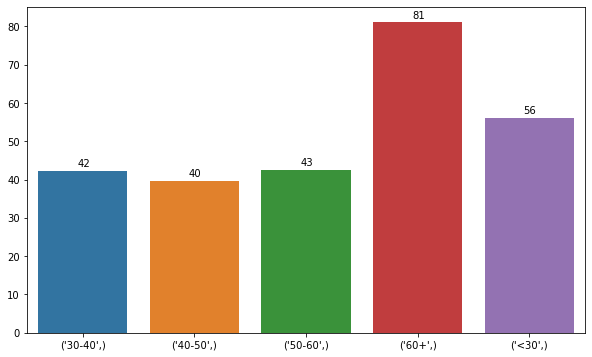

In [18]:
ds = df.groupby('age_cat')['deposit'].value_counts(sort=False)
fail_persent = []
for i in range (0, len(ds),2):
    dev = (ds[i+1]/(ds[i]+ds[i+1]))*100
    fail_persent.append(round(dev,2))

age_groups =[]
for k in ds.index:
    m = k[0]
    if m not in age_groups:
        age_groups.append(m)
    else:
        continue  
age_groups = list(dict.fromkeys(age_groups))

comparison = pd.DataFrame([fail_persent],
    index = ['fail_persent'],
    columns=[age_groups])

plt.figure(figsize=(10,6))
ax = sns.barplot(data=comparison)
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+1))

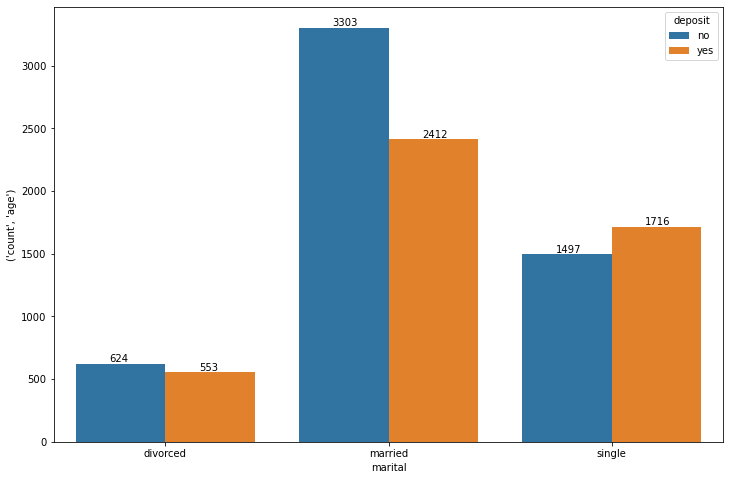

In [19]:
#Построим визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
pivot_table = df.pivot_table(
    values = 'age',
    index = ['marital', 'deposit'],
    aggfunc = ['count'],
    ).reset_index()

fig = plt.figure(figsize=(12, 8))

barplot = sns.barplot(
    data = pivot_table,
    x = 'marital',
    y = ('count', 'age'),
    hue = 'deposit',
    );
for p in barplot.patches:
        barplot.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+12))

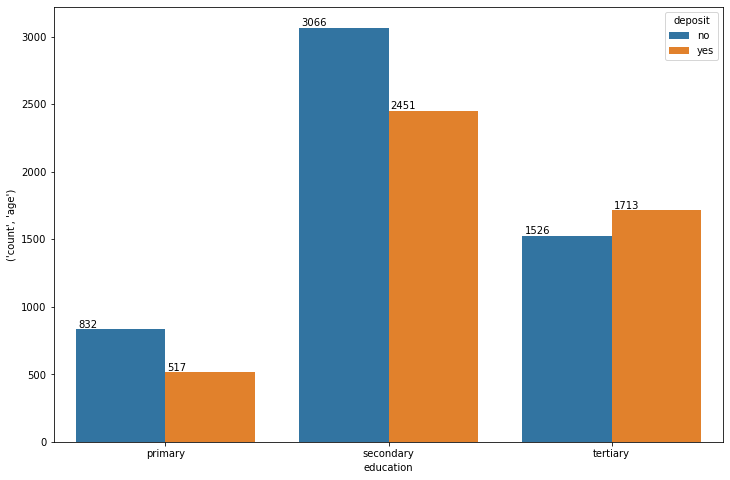

In [20]:
#Построим визуализации для открывших и неоткрывших депозит в зависимости от образования
pivot_table = df.pivot_table(
    values = 'age',
    index = ['education', 'deposit'],
    aggfunc = ['count'],
    ).reset_index()

fig = plt.figure(figsize=(12, 8))

barplot = sns.barplot(
    data = pivot_table,
    x = 'education',
    y = ('count', 'age'),
    hue = 'deposit',
    );
for p in barplot.patches:
        barplot.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height()+12))

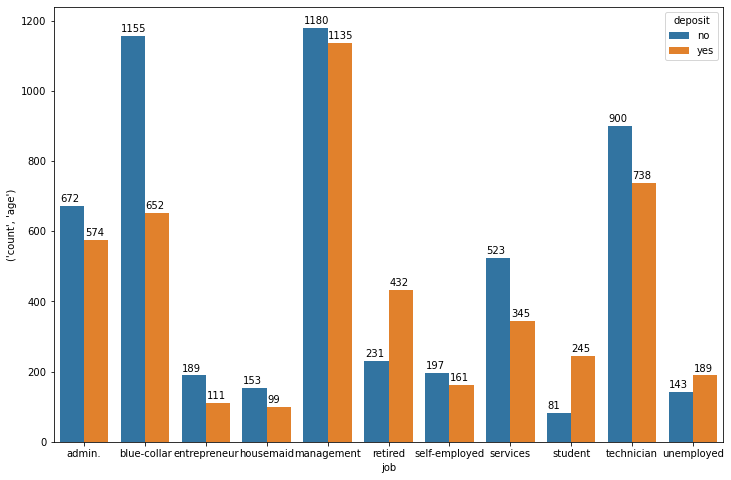

In [21]:
#Построим визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
pivot_table = df.pivot_table(
    values = 'age',
    index = ['job', 'deposit'],
    aggfunc = ['count'],
    ).reset_index()

fig = plt.figure(figsize=(12, 8))

barplot = sns.barplot(
    data = pivot_table,
    x = 'job',
    y = ('count', 'age'),
    hue = 'deposit',
    );
for p in barplot.patches:
        barplot.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height()+12))

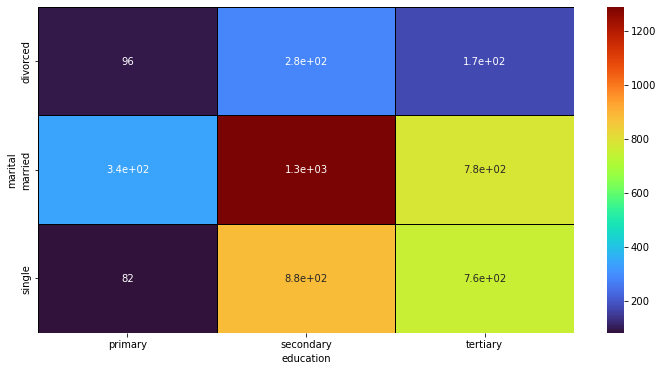

In [22]:
#Построим сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
df_dep = df[df['deposit']=='yes']
pivot_table = df_dep.pivot_table(
    values = 'age',
    index = 'marital',
    columns = 'education',
    aggfunc = 'count',
    )
fig_10 = plt.figure(figsize = (12, 6));

heatmap = sns.heatmap(pivot_table, annot = True, cmap = 'turbo', linewidths = 1, linecolor = 'black');

plt.show()

## Часть 3: Преобразование данных

In [23]:
#Преобразуем уровни образования
LE = LabelEncoder()
df['education'] = LE.fit_transform(df['education'])
df['age_cat'] = LE.fit_transform(df['age_cat'])

In [24]:
#Преобразуем бинарные переменные в представление из нулей и единиц
df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

In [25]:
#Создадим дамми-переменные
df['default'] = df['default'].apply(lambda x: 1 if x == 'yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x == 'yes' else 0)

In [26]:
categorial_features = ['job', 'marital', 'contact', 'month', 'poutcome']
df1= pd.get_dummies(df[categorial_features])
df = pd.concat([df,df1], axis = 1)
df.shape

(10105, 51)

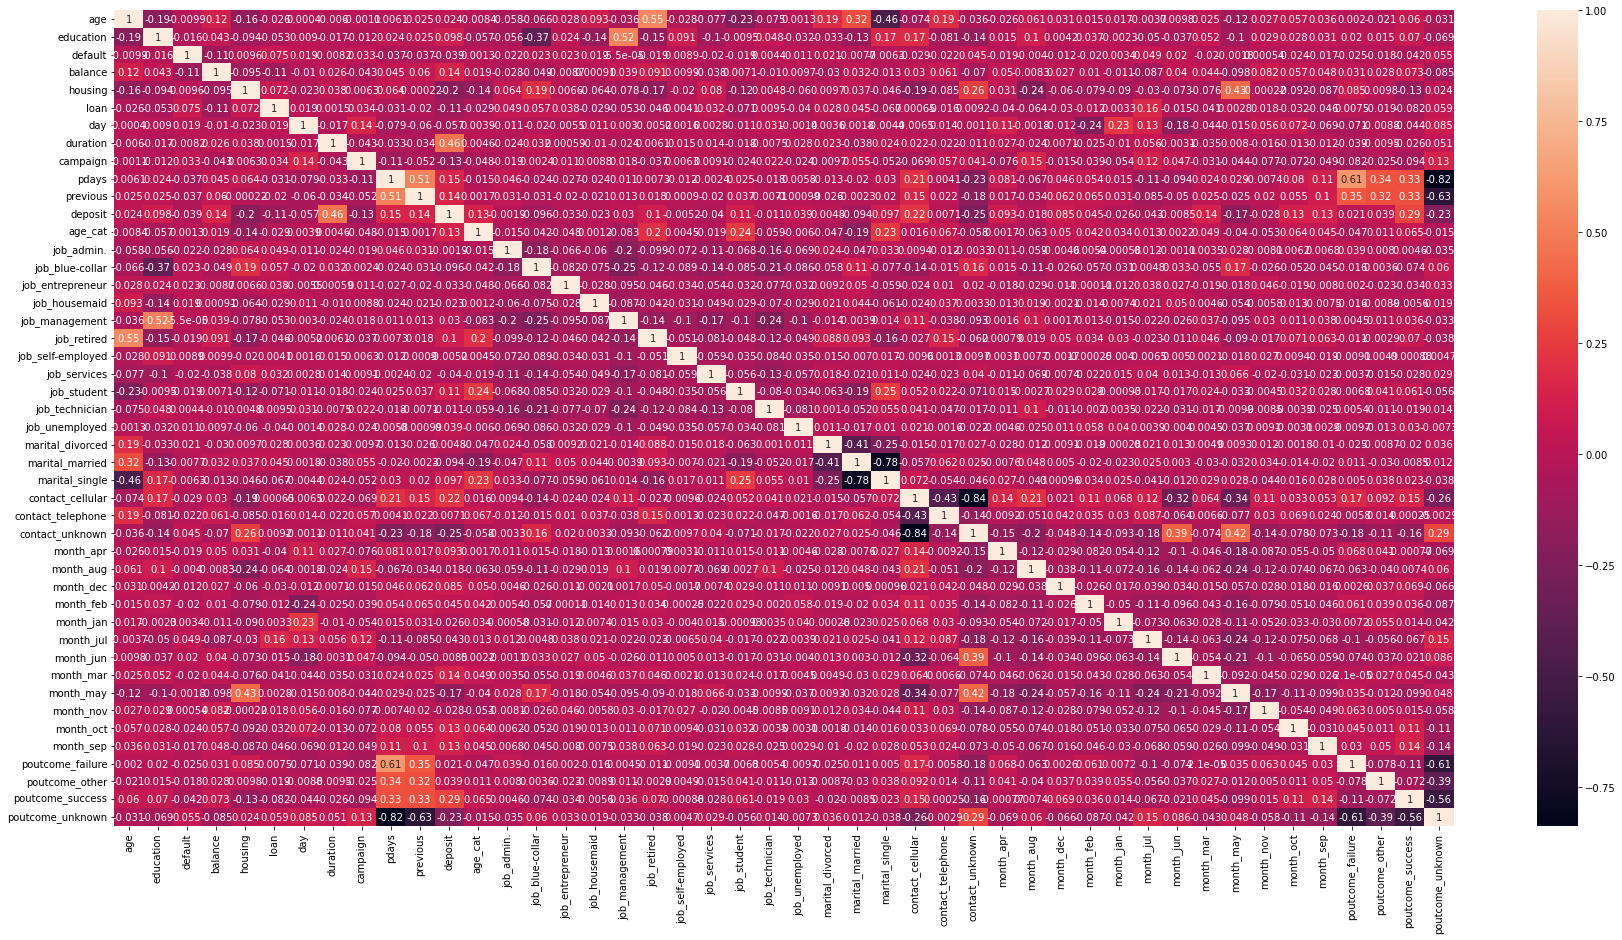

In [27]:
#Построим корреляционную матрицу и оценим данные на предмет наличия мультиколлинеарности
plt.figure(figsize = (30, 15))
sns.heatmap(df.corr(), annot = True);

In [28]:
df = df.drop(categorial_features, axis = 1)

In [29]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [41]:
#С помощью SelectKBest отберем 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
cols = selector.get_support(indices=True)
best_list = list(X_train.iloc[:,cols].columns)
best_list

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_cat',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

In [42]:
#Нормализуем данные с помощью minmaxsxaler
X_train = X_train[best_list]
X_test = X_test[best_list] 
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

In [43]:
#Обучим логистическую регрессию и рассчитаем метрики качества
#Создаём объект класса LogisticRegression
log_reg = linear_model.LogisticRegression(random_state=42, max_iter=1000, solver='sag')
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)
y_test_pred = log_reg.predict(X_test_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test_scaled, y_test)))

accuracy на тестовом наборе: 0.81


In [44]:
#Обучим решающие деревья, настроим максимальную глубину
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(criterion = 'entropy', random_state=42)
#Обучаем дерево по алгоритму CARTrint
dt.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train_scaled)
print("accuracy на обучающем наборе: {:.2f}".format(dt.score(X_train_scaled, y_train)))
print("accuracy на тестовом наборе: {:.2f}".format(dt.score(X_test_scaled, y_test)))

accuracy на обучающем наборе: 1.00
accuracy на тестовом наборе: 0.75


In [47]:
# Переберем различные максимальные глубины деревьев и найдем глубину дерева, для которой будет максимальное значение метрики accuracy, но при этом ещё не будет наблюдаться переобучения (т. е. не будет расти качество на обучающей выборке при неизменном качестве на тестовой).
accuracy_list = []
for i in range (1, 25):
    dt = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=i, random_state=42)
    dt.fit(X_train_scaled, y_train)
    accuracy_list.append(dt.score(X_test_scaled, y_test))

In [48]:
print("Максимальное значение accuracy: {:.2f}".format(max(accuracy_list)))

Максимальное значение accuracy: 0.81


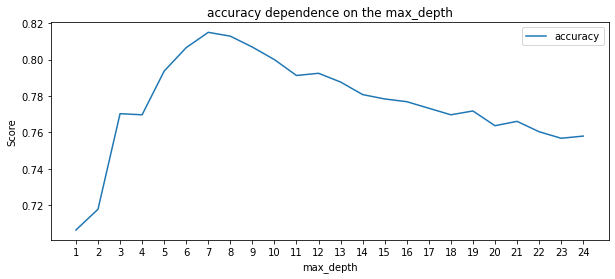

In [49]:
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
ax.plot(range (1, 25), accuracy_list, label='accuracy')
ax.set_title('accuracy dependence on the max_depth')
ax.set_xlabel('max_depth')
ax.set_ylabel('Score')
ax.set_xticks(range (1, 25)) 
ax.legend();

plt.show()

In [51]:
#Реализуем оптимизацию гиперпараметров с помощью GridSearch
from sklearn.model_selection import GridSearchCV
param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7],
              #'criterion' : ['entropy']
              }
            
grid_search = GridSearchCV(
        estimator=tree.DecisionTreeClassifier(
        random_state=42), 
        param_grid = param_grid, 
        cv=5, 
        n_jobs = -1
)  
%time grid_search.fit(X_train_scaled, y_train) 
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.5f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: user 218 ms, sys: 78.9 ms, total: 297 ms
Wall time: 2.34 s
f1_score на тестовом наборе: 0.80076
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}


In [52]:
#Оценим метрику f1_score на тестовой выборке для наилучшей комбинации перебираемых параметров.
dt = tree.DecisionTreeClassifier(min_samples_split = 2, max_depth = 7, random_state=42)
#Обучаем дерево по алгоритму CARTrint
dt.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.80


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

In [63]:
#Обучим на данных случайный лес
rf_clf = ensemble.RandomForestClassifier(
    n_estimators=100, 
    criterion='gini', 
    max_depth=10, 
    min_samples_leaf = 5, 
    random_state=42 
)
rf_clf.fit(X_train_scaled, y_train)
y_pred = rf_clf.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.80


In [66]:
#Используем для классификации градиентный бустинг и сравним качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(
    learning_rate=0.05, 
    n_estimators=300, 
    max_depth=5, 
    min_samples_leaf = 5,
    random_state=42 
)
gb.fit(X_train_scaled, y_train)
y_pred = gb.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_pred)))

f1_score на тестовом наборе: 0.82


In [67]:
#Объединим уже известные алгоритмы с помощью стекинга 
from sklearn.ensemble import StackingClassifier
estimators = [
    ('lr', linear_model.LogisticRegression(random_state=42, max_iter=1000, solver='sag')),
    ('dt',  tree.DecisionTreeClassifier(criterion = 'entropy', random_state=42))
]

model = StackingClassifier(
    estimators=estimators,
    final_estimator=GradientBoostingClassifier(
    learning_rate=0.05, 
    n_estimators=300, 
    max_depth=5, 
    min_samples_leaf = 5,
    random_state=42 
)
)
#Обучаем модель
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_pred)))

f1_score на тестовом наборе: 0.80


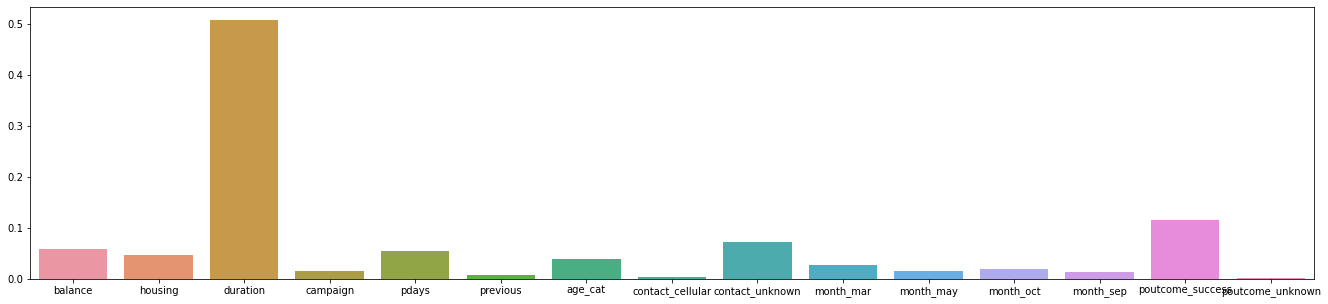

In [56]:
#Оценим, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
fig, ax = plt.subplots(figsize=(23, 5)) #фигура + координатная плоскость
feature = X_train.columns #признаки
feature_importances = gb.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature, y=feature_importances, ax=ax);

In [57]:
#Реализуем оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1);
  max_depth = trial.suggest_int('max_depth', 10, 30, 1);
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [60]:
%%time
import optuna
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-08-09 00:53:06,447] A new study created in memory with name: RandomForestClassifier
[I 2022-08-09 00:53:07,497] Trial 0 finished with value: 0.9213624234814001 and parameters: {'n_estimators': 171, 'max_depth': 22, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9213624234814001.
[I 2022-08-09 00:53:08,316] Trial 1 finished with value: 0.8451014310426167 and parameters: {'n_estimators': 161, 'max_depth': 12, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.9213624234814001.
[I 2022-08-09 00:53:09,329] Trial 2 finished with value: 0.8842302878598248 and parameters: {'n_estimators': 174, 'max_depth': 16, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9213624234814001.
[I 2022-08-09 00:53:10,112] Trial 3 finished with value: 0.8545113955666561 and parameters: {'n_estimators': 159, 'max_depth': 24, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.9213624234814001.
[I 2022-08-09 00:53:10,891] Trial 4 finished with value: 0.8513365640143817 and parameters: {'n

CPU times: user 16.8 s, sys: 81.6 ms, total: 16.9 s
Wall time: 16.9 s


In [71]:
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42 )
model.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=24, min_samples_leaf=2, n_estimators=137,
                       random_state=42)

In [73]:
y_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_pred)))

f1_score на тестовом наборе: 0.82
